*Reference - https://docs.pytorch.org/tutorials/beginner/fgsm_tutorial.html*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ignite
import json

# **Task 1 - Evaluation**

In [2]:
with open("/kaggle/input/final-project/TestDataSet/labels_list.json", "r") as f:
    indices = json.load(f)

indices = {int(k.split(":")[0]): k.split(" ")[-1] for k in indices}
offset = min(indices)

In [76]:
pretrained_model = torchvision.models.resnet34(weights="IMAGENET1K_V1")

In [77]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [78]:
ds_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.ImageFolder(
    root="/kaggle/input/final-project/TestDataSet",
    transform=ds_transform,
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.eval()
pretrained_model.to(device)

In [80]:
acc = ignite.metrics.Accuracy()
acc.reset()
topk = ignite.metrics.TopKCategoricalAccuracy(k=5)
topk.reset()

In [81]:
for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    labels += offset
    
    outputs = pretrained_model(images)
    
    acc.update([outputs, labels])
    topk.update([outputs, labels])

  0%|          | 0/500 [00:00<?, ?it/s]

In [82]:
print(f"Accuracy: {acc.compute()}")
print(f"Top-5 Accuracy: {topk.compute()}")

Accuracy: 0.76
Top-5 Accuracy: 0.942


In [88]:
def get_img(idx):
    dl = iter(dataloader)
    images = next(dl)
    for i in range(idx):
        images = next(dl)
    images = images[0].to(device)
    denorm = images * std.to(device).view(1, -1, 1, 1) + mean.to(device).view(1, -1, 1, 1)
    return denorm.cpu().squeeze().permute(1, 2, 0)

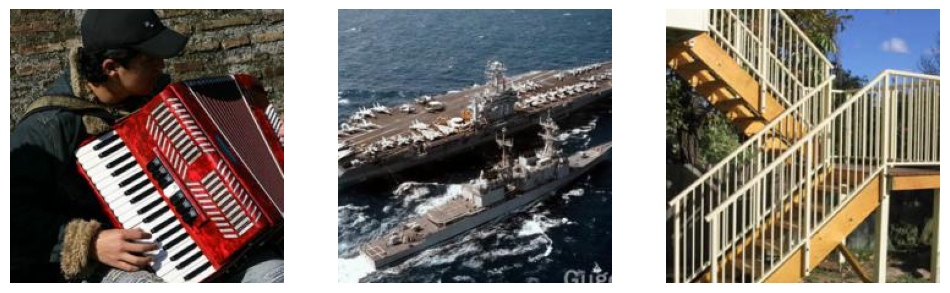

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for axis in ax:
    axis.set_axis_off()
ax[0].imshow(get_img(0))
ax[1].imshow(get_img(10))
ax[2].imshow(get_img(100))

# **Task 2 - FGSM**

In [101]:
acc = ignite.metrics.Accuracy()
acc.reset()
topk = ignite.metrics.TopKCategoricalAccuracy(k=5)
topk.reset()

In [102]:
epsilon = .02

ds = []

for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    labels += offset
    
    images.requires_grad = True
    outputs = pretrained_model(images)

    loss = F.cross_entropy(outputs, labels)
    pretrained_model.zero_grad()
    # calculate gradients
    loss.backward()
    # gradient of data
    data_grad = images.grad.data
    # denormalize data to initial scale
    images = images * std.to(device).view(1, -1, 1, 1) + mean.to(device).view(1, -1, 1, 1)
    # FGSM - add perturbation in direction of gradient
    perturbed = images + epsilon * data_grad.sign()
    # re-normalize
    images = torchvision.transforms.Normalize(mean=mean, std=std)(perturbed)
    # predict with perturbation
    outputs = pretrained_model(images)
 
    acc.update([outputs, labels])
    topk.update([outputs, labels])

    # save image to new dataset
    for b in range(images.shape[0]):
        ds.append(images[b])

  0%|          | 0/500 [00:00<?, ?it/s]

In [103]:
ds_2 = torch.stack(ds, dim=0)

In [104]:
print(f"Accuracy: {acc.compute()}")
print(f"Top-5 Accuracy: {topk.compute()}")

Accuracy: 0.034
Top-5 Accuracy: 0.218


In [139]:
def get_img_ds(img):
    images = img.to(device)
    denorm = images * std.to(device).view(1, -1, 1, 1) + mean.to(device).view(1, -1, 1, 1)
    return denorm.cpu().squeeze().permute(1, 2, 0).detach().numpy()

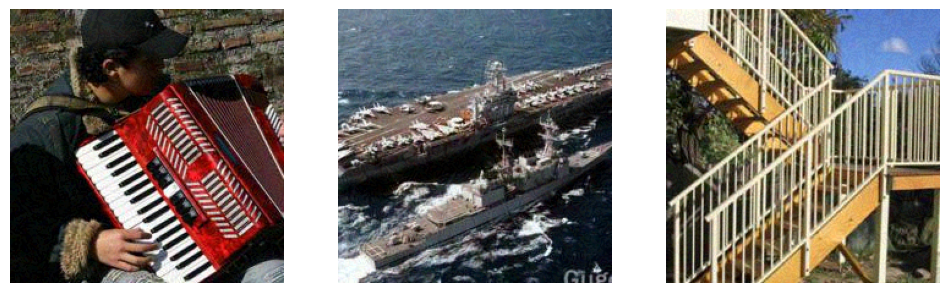

In [140]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for axis in ax:
    axis.set_axis_off()
ax[0].imshow(get_img_ds(ds_2[0]))
ax[1].imshow(get_img_ds(ds_2[10]))
ax[2].imshow(get_img_ds(ds_2[100]))

# **Task 3 - Iterative FGSM**

In [141]:
acc = ignite.metrics.Accuracy()
acc.reset()
topk = ignite.metrics.TopKCategoricalAccuracy(k=5)
topk.reset()

In [142]:
epsilon = .02
n = 10

ds = []

for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    labels += offset

    # run the same attack n times
    for _ in range(n):
        images = images.detach()
        images.requires_grad = True
        outputs = pretrained_model(images)
    
        loss = F.cross_entropy(outputs, labels)
        pretrained_model.zero_grad()
        # calculate gradients
        loss.backward()
        # gradient of data
        data_grad = images.grad.data
        # denormalize data to initial scale
        images = images * std.to(device).view(1, -1, 1, 1) + mean.to(device).view(1, -1, 1, 1)
        # FGSM - add perturbation in direction of gradient
        # we divide epsilon by n so that the total perturbation at the end of n iterations does not exceed epsilon
        perturbed = images + (epsilon / n) * data_grad.sign()
        # re-normalize
        images = torchvision.transforms.Normalize(mean=mean, std=std)(perturbed)
    
    # predict with perturbation
    outputs = pretrained_model(images)
 
    acc.update([outputs, labels])
    topk.update([outputs, labels])

    # save image to new dataset
    for b in range(images.shape[0]):
        ds.append(images[b])

  0%|          | 0/500 [00:00<?, ?it/s]

In [143]:
ds_3 = torch.stack(ds, dim=0)

In [144]:
print(f"Accuracy: {acc.compute()}")
print(f"Top-5 Accuracy: {topk.compute()}")

Accuracy: 0.0
Top-5 Accuracy: 0.016


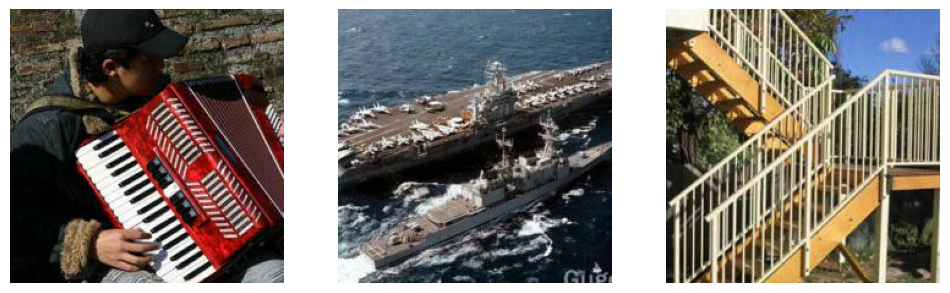

In [145]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for axis in ax:
    axis.set_axis_off()
ax[0].imshow(get_img_ds(ds_3[0]))
ax[1].imshow(get_img_ds(ds_3[10]))
ax[2].imshow(get_img_ds(ds_3[100]))

# **Task 4 - Patch Attack**

In [146]:
acc = ignite.metrics.Accuracy()
acc.reset()
topk = ignite.metrics.TopKCategoricalAccuracy(k=5)
topk.reset()

In [147]:
epsilon = .3
n = 10

ds = []

for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    labels += offset

    # run the same attack n times
    for _ in range(n):
        images = images.detach()
        images.requires_grad = True
        outputs = pretrained_model(images)
    
        loss = F.cross_entropy(outputs, labels)
        pretrained_model.zero_grad()
        # calculate gradients
        loss.backward()
        # gradient of data
        data_grad = images.grad.data
        # denormalize data to initial scale
        images_patch = images * std.to(device).view(1, -1, 1, 1) + mean.to(device).view(1, -1, 1, 1)
        # FGSM - add perturbation in direction of gradient
        # we divide epsilon by n so that the total perturbation at the end of n iterations does not exceed epsilon
        perturbed_patch = images_patch + (epsilon / n) * data_grad.sign()
        # re-normalize
        images_patch = torchvision.transforms.Normalize(mean=mean, std=std)(perturbed_patch)

        # select the 32x32 patch with largest gradients, this is the patch that has the most effect
        # first, find all patches
        patches = data_grad.abs().unfold(2, 32, 1).unfold(3, 32, 1)
        patches_sums = patches.sum(dim=(1, 4, 5))
        # get the patch with highest absolute value sum
        max_idx = torch.argmax(patches_sums)
        x, y = divmod(max_idx.item(), patches_sums.size(-1))
        
        mask = torch.zeros(images.shape, device=device)
        mask[:, :, x:x + 32, y:y + 32] = 1.0

        # set the patch to 0
        images = images * (1 - mask)
        # then, add the new values to that patch
        images = images + images_patch * mask
    
    # predict with perturbation
    outputs = pretrained_model(images)
 
    acc.update([outputs, labels])
    topk.update([outputs, labels])

    # save image to new dataset
    for b in range(images.shape[0]):
        ds.append(images[b])

  0%|          | 0/500 [00:00<?, ?it/s]

In [148]:
ds_4 = torch.stack(ds, dim=0)

In [149]:
print(f"Accuracy: {acc.compute()}")
print(f"Top-5 Accuracy: {topk.compute()}")

Accuracy: 0.196
Top-5 Accuracy: 0.536


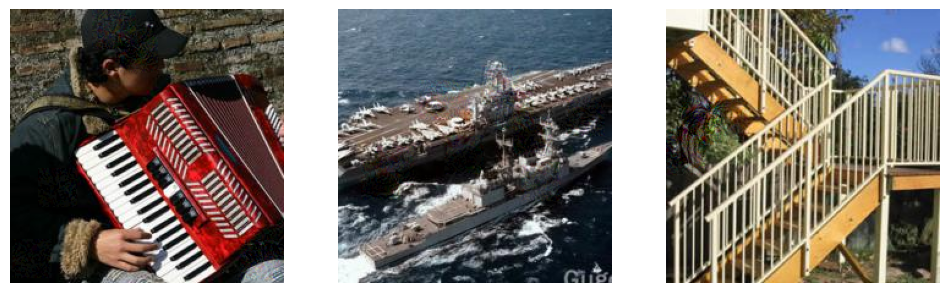

In [150]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for axis in ax:
    axis.set_axis_off()
ax[0].imshow(get_img_ds(ds_4[0]))
ax[1].imshow(get_img_ds(ds_4[10]))
ax[2].imshow(get_img_ds(ds_4[100]))

# **Task 5 - Attack Transfer**

In [43]:
new_model = torchvision.models.densenet121(weights="IMAGENET1K_V1")
new_model = new_model.to(device)

In [44]:
acc = ignite.metrics.Accuracy()
acc.reset()
topk = ignite.metrics.TopKCategoricalAccuracy(k=5)
topk.reset()

for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    labels += offset
    
    outputs = new_model(images)
    
    acc.update([outputs, labels])
    topk.update([outputs, labels])

print(f"Accuracy: {acc.compute()}")
print(f"Top-5 Accuracy: {topk.compute()}")

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 0.004
Top-5 Accuracy: 0.01


In [49]:
acc = ignite.metrics.Accuracy()
acc.reset()
topk = ignite.metrics.TopKCategoricalAccuracy(k=5)
topk.reset()

for i, (images, labels) in tqdm(enumerate(dataloader)):
    images = ds_2[i].to(device).unsqueeze(dim=0)
    labels = labels.to(device)
    labels += offset
    
    outputs = new_model(images)
    
    acc.update([outputs, labels])
    topk.update([outputs, labels])

print(f"Accuracy: {acc.compute()}")
print(f"Top-5 Accuracy: {topk.compute()}")

0it [00:00, ?it/s]

Accuracy: 0.006
Top-5 Accuracy: 0.012


In [50]:
acc = ignite.metrics.Accuracy()
acc.reset()
topk = ignite.metrics.TopKCategoricalAccuracy(k=5)
topk.reset()

for i, (images, labels) in tqdm(enumerate(dataloader)):
    images = ds_3[i].to(device).unsqueeze(dim=0)
    labels = labels.to(device)
    labels += offset
    
    outputs = new_model(images)
    
    acc.update([outputs, labels])
    topk.update([outputs, labels])

print(f"Accuracy: {acc.compute()}")
print(f"Top-5 Accuracy: {topk.compute()}")

0it [00:00, ?it/s]

Accuracy: 0.004
Top-5 Accuracy: 0.01


In [51]:
acc = ignite.metrics.Accuracy()
acc.reset()
topk = ignite.metrics.TopKCategoricalAccuracy(k=5)
topk.reset()

for i, (images, labels) in tqdm(enumerate(dataloader)):
    images = ds_4[i].to(device).unsqueeze(dim=0)
    labels = labels.to(device)
    labels += offset
    
    outputs = new_model(images)
    
    acc.update([outputs, labels])
    topk.update([outputs, labels])

print(f"Accuracy: {acc.compute()}")
print(f"Top-5 Accuracy: {topk.compute()}")

0it [00:00, ?it/s]

Accuracy: 0.008
Top-5 Accuracy: 0.01
